# Réseau neuronal mono couche - softmax

In [35]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [36]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

Deux étapes dans la création d'un réseau neuronal sous tensorflow:
- Creation du graphe qui indique comment est structuré le réseau
- Execution dans une session qui permet de définir le modèle (W et b)

Définition des structures utilisées:
- placeholder: tenseur réceptacle qui prend des données en entrée et qui doit toujours en contenir pour être évalué
- variable: tenseur qui va évoluer au fur et à mesure des calculs

## Pré traitement des données

On divise les tenseurs en entrée par 255 pour ramener toutes les valeurs entre 0 et 1 (impératif sinon on obtient péniblement une précision de 75%... et des Nan sur le calcul de l'entropie croisée)

In [37]:
x_train = x_train/255.
x_test  = x_test/255.

Transformation de Y en vecteurs de type "One hot encoded"

In [38]:
y_train = to_categorical(y_train, dtype='int8')
y_test  = to_categorical(y_test, dtype='int8')

## Définition du graphe

X est un tenseur dont la première dimension None correspondra à l'index du mini batch

In [39]:
X = tf.placeholder(tf.float32, shape=(None,28,28))

Y' (noté Y_) stocke les valeurs connues des nombres représentés sur chaque image

In [40]:
Y_ = tf.placeholder(tf.float32, shape=(None,10))

W et b vont varier lors de la phase d'apprentissage, ils sont stockés dans des tenseurs de type tf.variable

Poids W[784, 10] (type défini par défaut tf.float32)

In [41]:
W = tf.Variable(tf.zeros([784, 10]))

Biais b[10]

In [42]:
b = tf.Variable(tf.zeros([10]))

Transformation des images de X en des vecteurs (Réduction des 3 denières dimensions du tenseur X: 28 * 28 * 1  => 784). Le -1 indique que tensorflow doit s'arranger pour que cette dimension soit calculée de telle manière que la taille totale du tenseur reste constante.

In [43]:
Xv = tf.reshape(X, [-1, 784])

Définition du modèle de réseau neuronal utilisé

In [44]:
Y = tf.nn.softmax(tf.matmul(Xv,W) + b)

Détermination d'une mesure de la distance entre Y et Y' que l'on cherchera à minimiser: Entropie croisée (utilisation de reduce_sum qui permet de faire la somme de tous les éléments du tenseur). Les opérations * et log se font élément par élément du vecteur. `Y_ * tf.log(Y)` aura la dimension [100, 10] donc on somme sur 100*10 éléments.
> Problème avec reduce_mean les échelles de cross_entropy ne sont pas les mêmes sur train et test

In [45]:
# loss function - fonction de coût
cross_entropy = - tf.reduce_sum(Y_ * tf.log(Y))

Pourcentage de réponse correctes sur le batch.

Nombre de réponses justes: utilisation de argmax qui donne l'indice de la plus grande valeur d'une portion du tenseur selon un axe, ici 1 ce qui correspond aux lignes (Y_ est "one hot encoded"). is_correct est un vecteur de la taille du batch.

In [46]:
is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))

Calcul du % de réponses justes (utilisation d'une conversion de type pour faire calcul)

In [47]:
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

Méthode d'apprentissage: méthode de la descente de gradient de l'entropie croisée

Ici Tensorflow cherche à réduire la fonction de coût choisie (loss function = cross entropy) en faisant la dérivation formelle et en mettant à jour W et b en fonction du gradient calculé et du pas choisi pour l'apprentissage.

In [48]:
optimizer = tf.train.GradientDescentOptimizer(0.003)
train_step = optimizer.minimize(cross_entropy)

## Phase d'apprentissage

Variables utilisées pour la création des batches

In [49]:
n_train = x_train.shape[0] # Nombre de ligne de la matrice x_train
n_test  = x_test.shape[0]

Variables pour la visualisation

In [50]:
accuracy_train = []
accuracy_test = []
loss_train = []
loss_test = []
i_best = 0
accuracy_best = 0

Une époque correspond à une exploration complète du jeu de données d'entraînement
> Pourquoi `loss_train.append(loss/10.)` et pas `/100.` permet d'avoir des mêmes ordres de grandeur pour loss pour les deux jeux de données?

Epoch :  1
Epoch :  2
Epoch :  3
Epoch :  4


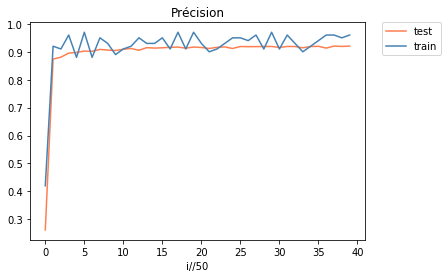

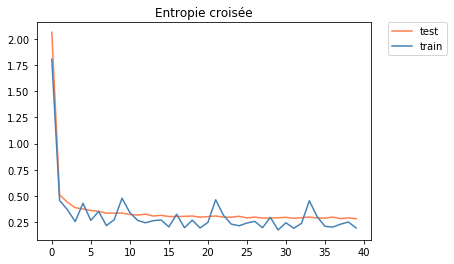

Best score for iteration 1850 	| Accuracy = 0.9206


In [51]:

sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)


for i in range(2000):
    epoch = (i*100)//n_train + 1
    
    # Chargement d'un batch d'images et des réponses correctes correspondantes
    batch_train_X  = x_train[(i*100)%n_train:((i+1)*100)%n_train]
    batch_train_Y_ = y_train[(i*100)%n_train:((i+1)*100)%n_train]
    # Dictionnaire de données en entrée
    train_data = {X: batch_train_X, Y_: batch_train_Y_}

    # Entrainement du réseau
    sess.run(train_step, feed_dict=train_data)
    
    # Visualisation de la progression
    if not (i*100)%(n_train):
        print("Epoch : ", epoch)
    if not i%50:
        # Pour le batch d'entraînement
        acc, loss = sess.run([accuracy, cross_entropy], feed_dict=train_data)
        accuracy_train.append(acc)
        loss_train.append(loss/100.)
        
        # Pour l'ensemble de test
        # L'utilisastion de batchs donne des scores arbitrairement hauts pour certains
        # Ce qui fausse l'évaluation
        #batch_test_X  = x_train[(i*100)%n_test:((i+1)*100)%n_test]
        #batch_test_Y_ = y_train[(i*100)%n_test:((i+1)*100)%n_test]
        #test_data = {X: batch_test_X, Y_: batch_test_Y_}
        test_data = {X: x_test, Y_: y_test}
        acc, loss = sess.run([accuracy, cross_entropy], feed_dict=test_data)
        accuracy_test.append(acc)
        loss_test.append(loss/n_test)
        if acc > accuracy_best:
            accuracy_best = acc
            i_best = i

# Représentation des résultats
# Précision
plt.plot(accuracy_test, c='coral', label='test')
plt.plot(accuracy_train, c='steelblue', label='train')
plt.xlabel('i//50')
plt.title('Précision')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
# Fonction de coût
plt.plot(loss_test, c='coral', label='test')
plt.plot(loss_train, c='steelblue', label='train')
plt.title('Entropie croisée')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
# Meilleur résultat sur un batch de test
print("Best score for iteration {} \t| Accuracy = {:.4f}".format(i_best, accuracy_best ))


In [52]:
sess.close()

92,06% de réussite sur un jeu de données jamais rencontrées lors de l'apprentissage, pas mal déjà! Voyons voir si l'on peut faire mieux?